# Customer Churn Analysis by Supervised Models

## Data and Motivation:

This project is based on studying the customer churn prediction, using Telco Customer Churn data set provided by IBM Analytics. The dataset can be retrieved from [this page](https://www.ibm.com/communities/analytics/watson-analytics-blog/predictive-insights-in-the-telco-customer-churn-data-set/).<br>

The dataset already provides whether a labeled column whether a customer is left or not within the last month. Besides, there are features including number of months that customer stayed, type of services the customer used (phone, internet, online security, etc.), customer's account information (contract, payment method, paperless billing, monthly charges), and customer's demographic characteristics (gender, age range, and if they have partners and dependents).<br>

The objective of this project is to predict whether the customers would churn or not, and what features affect customer churn or retention. To do such analysis, I employ different supervised learning models including Logistic regression, k Nearest Neighborhood classification, Random Forest and Support Vector Machine (SVM) classifications.<br>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches #for custom legends
import seaborn as sns
from lifelines import KaplanMeierFitter #survival analysis: Kaplan_Meier
from lifelines.statistics import logrank_test #survival: log rank test 
from lifelines import CoxPHFitter  #survival: fitting Cox model
from lifelines.utils import k_fold_cross_validation #survival: cross-validation
%matplotlib inline
import scipy.stats as stats
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score   #likelihood of model distinguishing observations from two classes.
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn import neighbors
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

In [2]:
# reading data
df=pd.read_csv('/Users/Liuna/Desktop/ibm_data.csv')

In [3]:
# dimensions of dataset
df.shape

(7043, 21)

* This dataset has 7,043 columns and 21 rows.

In [4]:
# name of columns
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [5]:
# data type
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [6]:
#quick check of data
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# tabulating outcome varible: customer churn
df.Churn.value_counts()/len(df)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

* The **outcome** variable is whether customer **churned or not**.
* As we can see here, the dataset is imbalanced. Therefore we should make the dataset more balanced by using resampling methods, including overfit and underfit resampling.
* Here, I employ **class_weight** option for most of my models to fix the imbalance.

In [8]:
# checking for duplicate id:
print(any(df['customerID'].duplicated()))  

False


In [9]:
# checking for missing value, nan
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

* The dataset has no missing values.
* There are 7,043 unique customer ids in this dataset.

In [10]:
# getting an idea how features should be transformed to binary variables
ls_ft= ['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
       'StreamingTV','StreamingMovies','Contract','PaymentMethod']

for l in ls_ft:
    print(df[l].value_counts() )

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Fiber optic    3096
DSL            2421
No             1526
Name: InternetService, dtype: int64
No                     3498
Yes                    2019
No internet service    1526
Name: OnlineSecurity, dtype: int64
No                     3088
Yes                    2429
No internet service    1526
Name: OnlineBackup, dtype: int64
No                     3095
Yes                    2422
No internet service    1526
Name: DeviceProtection, dtype: int64
No                     3473
Yes                    2044
No internet service    1526
Name: TechSupport, dtype: int64
No                     2810
Yes                    2707
No internet service    1526
Name: StreamingTV, dtype: int64
No                     2785
Yes                    2732
No internet service    1526
Name: StreamingMovies, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Contract, d

In [11]:
# Converting yes/no columns to binary 1/0.
ls_features= ['Partner','Dependents','PhoneService','PaperlessBilling','Churn'] 
for ls_f in ls_features:
    df[ls_f]= np.where(df[ls_f]=="Yes",1,0)
    
# gender is male=1, otherwise=0
df['gender']= np.where(df['gender']=="Male",1,0)    

# assigning dummy for each payment method
ls_payment=['Month-to-month','Two year','One year']
for ls_p in ls_payment:
    df[ls_p]=np.where(df['Contract']==ls_p,1,0) 
    
# if payment is paid by either automatic methods=1, otherswie, paying by check=0   
df["Payment_automatic"] = np.where((df['PaymentMethod']=='Bank transfer (automatic)') | 
                                    (df['PaymentMethod']=='Credit card (automatic)'),1, 0)  

# string to numerical values
df['TotalCharges']= pd.to_numeric(df['TotalCharges'], errors='coerce')


# changing the column values for No,Yes,No internet service to 0/1 where
# zero is for "No/No internet service" and one for "Yes"
ls_no_internet=['OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV',
                'StreamingMovies','MultipleLines']
for ls_n in ls_no_internet:
    df.loc[df[ls_n] !='Yes', ls_n]=0
    df.loc[df[ls_n] =='Yes', ls_n]=1

# internet service no as 0, otherwise 1    
df.loc[df.InternetService !='No', 'InternetService']=1
df.loc[df.InternetService =='No', 'InternetService']=0    

# dropping these columns
df.drop(columns=['customerID', 'Contract','PaymentMethod'], inplace=True)

In [12]:
# checking data type after transformation
df.dtypes

gender                 int64
SeniorCitizen          int64
Partner                int64
Dependents             int64
tenure                 int64
PhoneService           int64
MultipleLines          int64
InternetService        int64
OnlineSecurity         int64
OnlineBackup           int64
DeviceProtection       int64
TechSupport            int64
StreamingTV            int64
StreamingMovies        int64
PaperlessBilling       int64
MonthlyCharges       float64
TotalCharges         float64
Churn                  int64
Month-to-month         int64
Two year               int64
One year               int64
Payment_automatic      int64
dtype: object

In [13]:
# quick check on data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
gender               7043 non-null int64
SeniorCitizen        7043 non-null int64
Partner              7043 non-null int64
Dependents           7043 non-null int64
tenure               7043 non-null int64
PhoneService         7043 non-null int64
MultipleLines        7043 non-null int64
InternetService      7043 non-null int64
OnlineSecurity       7043 non-null int64
OnlineBackup         7043 non-null int64
DeviceProtection     7043 non-null int64
TechSupport          7043 non-null int64
StreamingTV          7043 non-null int64
StreamingMovies      7043 non-null int64
PaperlessBilling     7043 non-null int64
MonthlyCharges       7043 non-null float64
TotalCharges         7032 non-null float64
Churn                7043 non-null int64
Month-to-month       7043 non-null int64
Two year             7043 non-null int64
One year             7043 non-null int64
Payment_automatic    7043 no

In [14]:
# checking the rows with missing total charges
df.loc[df['TotalCharges'].isna()==True]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,Month-to-month,Two year,One year,Payment_automatic
488,0,0,1,1,0,0,0,1,1,0,...,1,0,1,52.55,NaN,0,0,1,0,1
753,1,0,0,1,0,1,0,0,0,0,...,0,0,0,20.25,NaN,0,0,1,0,0
936,0,0,1,1,0,1,0,1,1,1,...,1,1,0,80.85,NaN,0,0,1,0,0
1082,1,0,1,1,0,1,1,0,0,0,...,0,0,0,25.75,NaN,0,0,1,0,0
1340,0,0,1,1,0,0,0,1,1,1,...,1,0,0,56.05,NaN,0,0,1,0,1
3331,1,0,1,1,0,1,0,0,0,0,...,0,0,0,19.85,NaN,0,0,1,0,0
3826,1,0,1,1,0,1,1,0,0,0,...,0,0,0,25.35,NaN,0,0,1,0,0
4380,0,0,1,1,0,1,0,0,0,0,...,0,0,0,20.00,NaN,0,0,1,0,0
5218,1,0,1,1,0,1,0,0,0,0,...,0,0,1,19.70,NaN,0,0,0,1,0
6670,0,0,1,1,0,1,1,1,0,1,...,1,0,0,73.35,NaN,0,0,1,0,0


* Total charges have missing values. 
* Looking at missing values of total charges, it is noticeable that the missing values are related to customers with tenure value equals to zero.
* Zero tenure means that the customers recently subscribed for the service.
* Therefore, missing Total charges can be replaced by zero.

In [15]:
# replacing missing values in total cahrges column with zero
df[df['TotalCharges'].isna()==True] = 0

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
gender               7043 non-null int64
SeniorCitizen        7043 non-null int64
Partner              7043 non-null int64
Dependents           7043 non-null int64
tenure               7043 non-null int64
PhoneService         7043 non-null int64
MultipleLines        7043 non-null int64
InternetService      7043 non-null int64
OnlineSecurity       7043 non-null int64
OnlineBackup         7043 non-null int64
DeviceProtection     7043 non-null int64
TechSupport          7043 non-null int64
StreamingTV          7043 non-null int64
StreamingMovies      7043 non-null int64
PaperlessBilling     7043 non-null int64
MonthlyCharges       7043 non-null float64
TotalCharges         7043 non-null float64
Churn                7043 non-null int64
Month-to-month       7043 non-null int64
Two year             7043 non-null int64
One year             7043 non-null int64
Payment_automatic    7043 no

## Heatmap of Correlation among Variables

**Heatmap** is based on the correlation matrix of features and outcome variable (customer churn).

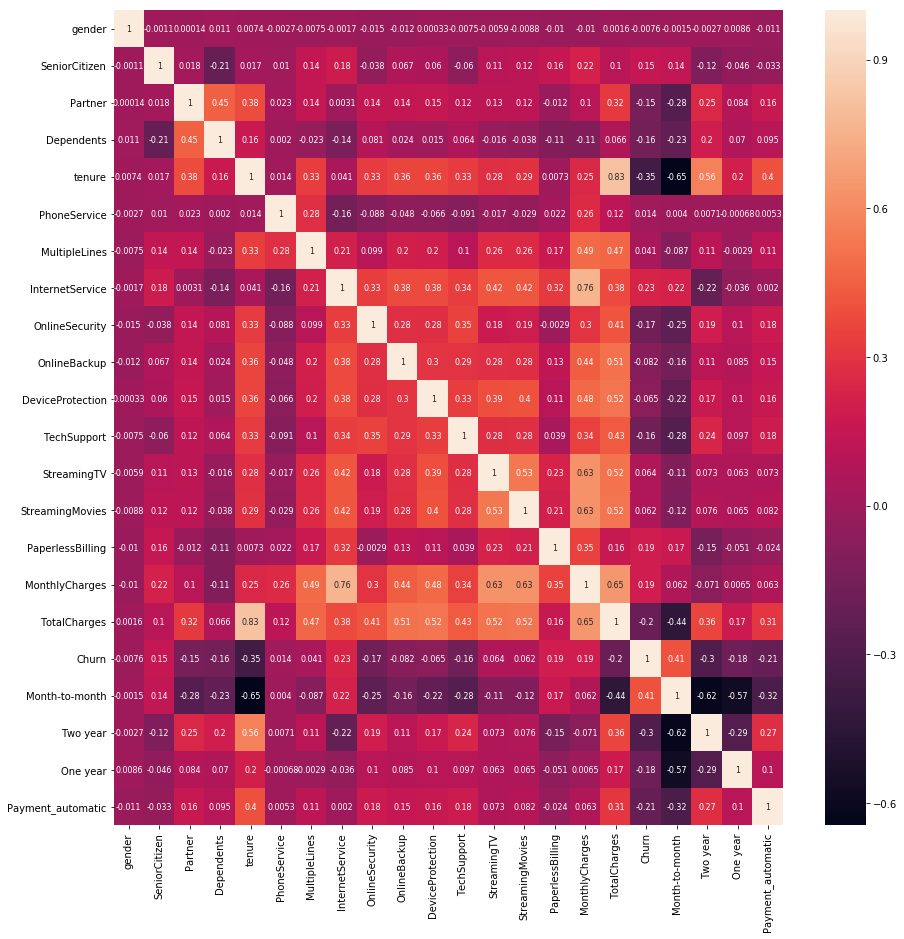

In [17]:
# correlation matrix.
corrmat = df.corr()   #I could also use print(corrmat)

f, ax = plt.subplots(figsize=(15, 15))

# heatmap where xticklabels and yticklabels assign the values and annot_kws is the size of corr in each block
sns.heatmap(corrmat, xticklabels=corrmat.columns.values, yticklabels=corrmat.columns.values,
            annot = True, annot_kws={'size':8})   

plt.show()

In [18]:
df.drop('TotalCharges', axis=1, inplace=True)

* The heatmap shows the correlation among feature in pairs. 
* The correlation is a number between -1 and 1 which indicates perfect positive correlation for 1, and perfect negative correlation for -1. 
* I drop features which have  correlation above a threshold of .75.
* Based on the heatmap the "total charges" and "tenure" are highly correlated (.83). Besides "total charges" is correlated relatively high (.65) with "monthly charges". 

### Creating More Features by Generating Interaction Terms

In [18]:
features= df.loc[:, ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'MonthlyCharges', 
       'Month-to-month', 'Two year', 'One year', 'Payment_automatic']]

# creating intercation terms
for i in range(0, features.columns.size-1):
    for j in range(0, features.columns.size-1):
        col1 = str(features.columns.values[i])
        col2 = str(features.columns.values[j])
        # multiply fields together (we allow values to be squared)
        if i != j:
            name = col1 + "*" + col2
            df = pd.concat([df, pd.Series(features.iloc[:,i] * features.iloc[:,j], name=name)], axis=1)

In [19]:
#checking dimensions
df.shape

(7043, 364)

* After creating interaction terms, the number of features is increased from 20 to 362.
* Next step is to **reduce dimensionality** by dropping the features which do not explain the variation of the outcome variable.

### Feature Selection:

In [20]:
Y=df['Churn']
X=df.drop('Churn', axis=1)    # all features: including interaction

#feature selection: only numerical ones
X_names = X.columns.get_values().tolist()


# feature selection by random forest


#from sklearn.feature_selection import SelectFromModel
# from sklearn.metrics import accuracy_score

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#feature selection by random forest
clf = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)

clf.fit(X_train, Y_train)

for feature in zip(X_names, clf.feature_importances_):
    print(feature)

('gender', 0.001264405794564395)
('SeniorCitizen', 0.0010987455761049165)
('Partner', 0.0012078776552282666)
('Dependents', 0.0013498881249371926)
('tenure', 0.015431001807491268)
('PhoneService', 0.0)
('MultipleLines', 0.0009224740828398086)
('InternetService', 2.2711833616387158e-07)
('OnlineSecurity', 0.0007791834994375984)
('OnlineBackup', 0.00139638584803279)
('DeviceProtection', 0.001235400242776428)
('TechSupport', 0.0010636568976781701)
('StreamingTV', 0.0006598398061203562)
('StreamingMovies', 0.0011672899073418715)
('PaperlessBilling', 0.000697136984324261)
('MonthlyCharges', 0.0181727347071257)
('TotalCharges', 0.02616872417813787)
('Month-to-month', 0.00021498262105748876)
('Two year', 3.117001575150075e-05)
('One year', 5.1466076677722255e-05)
('Payment_automatic', 0.005093337537276742)
('gender*SeniorCitizen', 0.0006115743918678905)
('gender*Partner', 0.0012622064788650746)
('gender*Dependents', 0.0013389994172648273)
('gender*tenure', 0.006787284755691858)
('gender*Phone

In [21]:
#setting threshold for features explaining variations in price
sfm = SelectFromModel(clf, threshold=0.02)

sfm.fit(X_train, Y_train)

for feature_list_index in sfm.get_support(indices=True):
    print(X_names[feature_list_index])

TotalCharges
tenure*PhoneService
tenure*MonthlyCharges
tenure*Month-to-month
PhoneService*tenure
InternetService*Month-to-month
PaperlessBilling*MonthlyCharges
MonthlyCharges*tenure
MonthlyCharges*PhoneService
MonthlyCharges*InternetService
Month-to-month*tenure
Month-to-month*MonthlyCharges


In [22]:
X_important_train = sfm.transform(X_train)
X_important_test = sfm.transform(X_test)

## Supervised Learning Models

The supervised learning models I will use here include Logistic regression, Support Vector Machine, k-Nearest Neighbors, and Random Forest.

I use the following classification metrics to evaluate the results of different models:

* Confusion matrix: presents the correct and false predictions of a classifier.
* The entries of confusion matrix consist of true negative, false positive, false negative and true positive which can be illustrated as follows:

| Labels | Predicted No Churn  | Predicted Churn |
|-------------| ------------- | -------------|
|No Churn Cases| True Negative  | False Postive  |
|Churn Cases| False Negative | True Positive  |



* Accuracy: number of correct predictions made as a ratio of all predictions made.
* Accuracy can be calculated by dividing the diagonal numbers of confusion matrix over all other entries in the confusion matrix.

** Accuracy is not the best metric to use here, because my sample does not have an equal number of observations for each class, i.e., binary outcome variable of customer churn has 73.5 percent as "No", and 26.5 percent as "Yes".

* Precision: the ratio of true positive over summation of true positive and false positive.
* Recall: the ratio of true positive over summation of true positive and false negative.
* F1-score: the product of summation of precision and recall over summation of precision and recall multiplied by 2, which is a balanced measure of precision and recall.	

* The goal is to predict the customer churn. 
* While I will use these metrics to evaluate the models, my main focus is on **precision metric** when customer churn occurs, i.e., outcome variable equals to 1.

#### Ridge and Lasso Logistic Regressions: 

* I run four logistic regressions including two ridge and two lasso logistic regressions. 
* My first ridge and lasso logistic regressions are not corrected for the imbalance of the dataset.
* My second ridge and lasso logistic regressions are corrected for the imbalance of the dataset by using **class_weight= balanced** option.

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy of ridge logistic regression on test set:0.7865593942262187

Classification report of ridge logistic regression on test set: 
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1560
           1       0.62      0.48      0.54       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.72      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



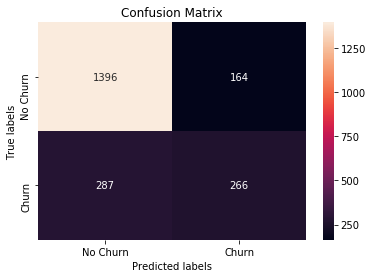

In [23]:
# Logistic regression

#Ridge logistic
#l2=ridge, n_jobs=-1 uses are processors. 
lr_ridge = LogisticRegression(penalty='l2',random_state=0, n_jobs=-1)   
                                           
lr_ridge.fit(X_important_train,Y_train)
Y_lr_important_pred = lr_ridge.predict(X_important_test)

print('Accuracy of ridge logistic regression on test set:' + str(lr_ridge.score(X_important_test, Y_test)))

print('\nClassification report of ridge logistic regression on test set: \n' +
      str(classification_report(Y_test, Y_lr_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_lr_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy of ridge logistic regression on test set:0.7411263606247042

Classification report of ridge logistic regression on test set: 
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1560
           1       0.50      0.74      0.60       553

   micro avg       0.74      0.74      0.74      2113
   macro avg       0.70      0.74      0.70      2113
weighted avg       0.79      0.74      0.75      2113



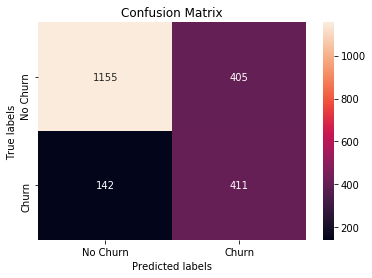

In [24]:
# Logistic regression

#Ridge logistic
#l2=ridge, class_weight: for dealing with imbalance data, , n_jobs=-1 uses are processors. 
lr_ridge = LogisticRegression(penalty='l2',class_weight='balanced'
                                           ,random_state=0, n_jobs=-1)   

lr_ridge.fit(X_important_train,Y_train)
Y_lr_important_pred = lr_ridge.predict(X_important_test)

print('Accuracy of ridge logistic regression on test set:'+ str(lr_ridge.score(X_important_test, Y_test)))
print('\nClassification report of ridge logistic regression on test set: \n'
      + str(classification_report(Y_test, Y_lr_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_lr_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells


# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy of lasso logistic regression classifier on test set:0.7860861334595362

Classification report of lasso logistic regression on test set:
              precision    recall  f1-score   support

           0       0.84      0.88      0.86      1560
           1       0.61      0.51      0.56       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.72      0.70      0.71      2113
weighted avg       0.78      0.79      0.78      2113



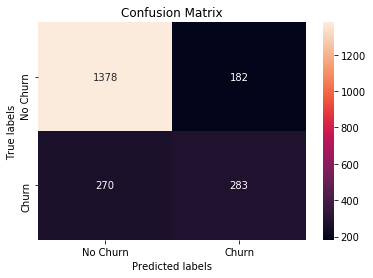

In [25]:
#Lasso logistic

#l1=lasso, n_jobs=-1 uses are processors. 
ll_lasso = LogisticRegression(penalty='l1',random_state=0, n_jobs=-1) 
                                             

ll_lasso.fit(X_important_train,Y_train)
Y_ll_important_pred = ll_lasso.predict(X_important_test)

print('Accuracy of lasso logistic regression classifier on test set:' +
     str(ll_lasso.score(X_important_test, Y_test)))
print('\nClassification report of lasso logistic regression on test set:\n'+
      str(classification_report(Y_test, Y_ll_important_pred)))


# #confusion matrix
cm= confusion_matrix(Y_test, Y_ll_important_pred)  
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

#labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1296: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Accuracy of lasso logistic regression classifier on test set:0.7406530998580217

Classification report of lasso logistic regression on test set:
              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1560
           1       0.50      0.74      0.60       553

   micro avg       0.74      0.74      0.74      2113
   macro avg       0.70      0.74      0.70      2113
weighted avg       0.79      0.74      0.75      2113



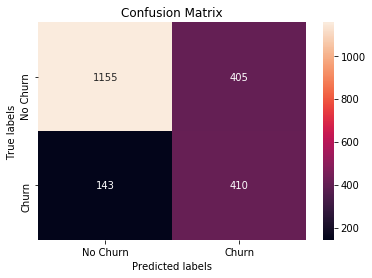

In [26]:
#Lasso logistic

#l1=lasso, class_weight: for dealing with imbalance data, , n_jobs=-1 uses are processors. 
ll_lasso = LogisticRegression(penalty='l1',class_weight='balanced'
                                           ,random_state=0, n_jobs=-1)   

ll_lasso.fit(X_important_train,Y_train)
Y_ll_important_pred = ll_lasso.predict(X_important_test)

print('Accuracy of lasso logistic regression classifier on test set:' +
     str(ll_lasso.score(X_important_test, Y_test)))
print('\nClassification report of lasso logistic regression on test set:\n'+
      str(classification_report(Y_test, Y_ll_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_ll_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

Logistic Ridge Regression results:<br>

Ridge performs **L2 regularization** on logistic regression which is the default option of logistic regression.<br>

* Accuracy of logistic ridge regression is 74% whereas, before correcting for imbalance precision is  79%.<br>
* Precision of logistic ridge regression is 50% for identifying the customer churn whereas, before correcting for imbalance precision is  62%.<br>
* Recall of logistic ridge regression is 74% for identifying the customer churn whereas, before correcting for imbalance precision is  48%.<br>

Logistic Lasso Regression results:<br>
Lasso performs **L1 regularization** on logistic regression. <br>
* Accuracy of logistic lasso regression is 74% whereas, before correcting for imbalance precision is  79%.<br>
* Precision of logistic lasso regression is 50% for identifying the customer churn whereas, before correcting for imbalance precision is  61%.<br>
* Recall of logistic lasso regression is 74% for identifying the customer churn whereas, before correcting for imbalance precision is  51%.

After performing feature selection, there are not a large number of features to choose. Therefore, in this case, logistic ridge regression is superior compared to logistic lasso regression. Lasso regularization assigns zero to some features whereas ridge regularization keeps all features.

#### Support Vector Machine (SVM) Classification:

* I use grid search to find the best values for parameters within a set of parameters for tuning SVM model. 
* To save the time of running grid search, I employ the default kernel option which is 'rbf'.
* For tunning parameters, I include penalty parameter C of the error term and gamma for Kernel coefficient of rbf.
* Downsides of using grid search are the algorithm picks one of the parameters among other specified parameters, whereas there might be other options which work better and excluded in grid search.

In [27]:
#SVM
    
svc = SVC()

param_grid = {'C': [0.01,0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01,0.001]} #kernal is rbf
              
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10)
CV_svc.fit(X_important_train,Y_train)

print (CV_svc.best_params_)

{'C': 1, 'gamma': 0.001}


Accuracy of SVM classifier on test set:0.7785139611926172

Classification report of SVM classifier on test set:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      1560
           1       0.64      0.36      0.46       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.72      0.64      0.66      2113
weighted avg       0.76      0.78      0.76      2113



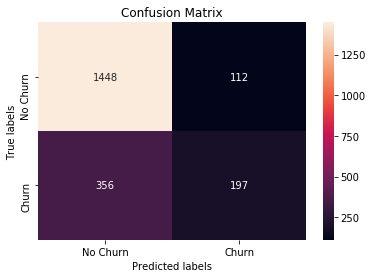

In [28]:
svc_simple = SVC(gamma= 0.001, random_state=0)
svc_simple.fit(X_important_train,Y_train)
svc_simple_important_pred = svc_simple.predict(X_important_test)

print('Accuracy of SVM classifier on test set:'+ str(svc_simple.score(X_important_test, Y_test)))

print('\nClassification report of SVM classifier on test set:\n'+
     str(classification_report(Y_test, svc_simple_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, svc_simple_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

In [29]:
#SVM using balanced version

svc = SVC()

param_grid = {'C': [0.01,0.1, 1, 10, 100],'gamma': [1, 0.1, 0.01,0.001] , 'class_weight':['balanced']} 
#kernal is rbf
              
CV_svc = GridSearchCV(estimator=svc, param_grid=param_grid, cv= 10)
CV_svc.fit(X_important_train,Y_train)

print (CV_svc.best_params_)

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'class_weight': 'balanced', 'gamma': 0.001}


Accuracy of SVM classifier on test set:0.7643161381921438

Classification report of SVM classifier on test set:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84      1560
           1       0.55      0.52      0.54       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.69      0.69      0.69      2113
weighted avg       0.76      0.76      0.76      2113



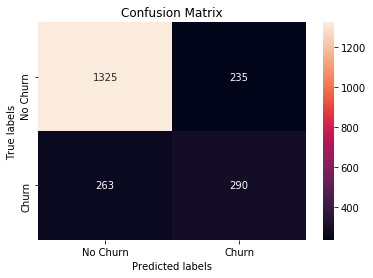

In [30]:
svc = SVC(C=1,gamma = 0.001, class_weight='balanced',random_state=0)
svc.fit(X_important_train,Y_train)
svc_important_pred = svc.predict(X_important_test)

print('Accuracy of SVM classifier on test set:'+ str(svc.score(X_important_test, Y_test)))

print('\nClassification report of SVM classifier on test set:\n'+
     str(classification_report(Y_test, svc_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, svc_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

* Accuracy of SVM classification is 73% whereas, before correcting for imbalance precision is  78%.<br>
* Precision of SVM classification is 49% for identifying the customer churn whereas, before correcting for imbalance precision is  64%.<br>
* Recall of SVM classification is 65% for determining the customer churn whereas, before correcting for imbalance precision is  36%.<br>

SVM tries to fit the widest gap between two classes here, and fixing for imbalance provides the correct result.

#### K-Nearest Neighborhood (kNN) Classification:

* kNN predicts by averaging the k neighbors nearest to a given data point.
* Sklearn does not provide any options to fix for the imbalance of dataset, i.e., there is no class_weight=balanced option.
* I use different numbers of neighbors and different types of weights (uniform and distance) to run following kNN classifications.

Accuracy of K-Nearest Neighborhood classifier on test set:0.7652626597255088

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      1560
           1       0.56      0.47      0.51       553

   micro avg       0.77      0.77      0.77      2113
   macro avg       0.69      0.67      0.68      2113
weighted avg       0.75      0.77      0.76      2113

kNN cross validation scores: [0.77406282 0.77789047 0.76572008 0.77789047 0.75634518]


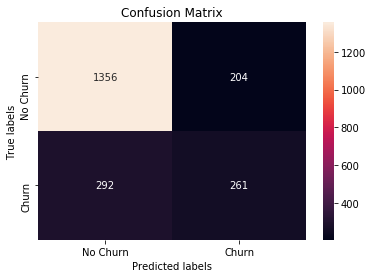

In [31]:
# weights=uniform
knn = neighbors.KNeighborsClassifier(n_neighbors=5 , weights='uniform')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)

print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))
print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+
     classification_report(Y_test, Y_knn_important_pred))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

Accuracy of K-Nearest Neighborhood classifier on test set:0.7610033128253668

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      1560
           1       0.55      0.46      0.50       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.69      0.66      0.67      2113
weighted avg       0.75      0.76      0.75      2113

kNN cross validation scores: [0.7710233  0.77687627 0.7525355  0.77281947 0.75736041]


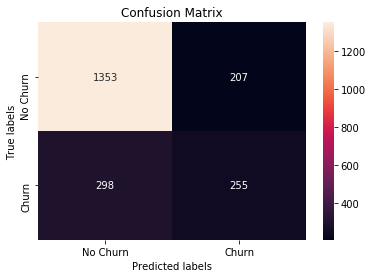

In [32]:
#knn with weights distance, neighbors=5
knn = neighbors.KNeighborsClassifier(n_neighbors=5 , weights='distance')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)


print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))

print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+
     str(classification_report(Y_test, Y_knn_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

Accuracy of K-Nearest Neighborhood classifier on test set:0.7671557027922385

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1560
           1       0.57      0.43      0.49       553

   micro avg       0.77      0.77      0.77      2113
   macro avg       0.69      0.66      0.67      2113
weighted avg       0.75      0.77      0.76      2113

kNN cross validation scores: [0.78318136 0.78093306 0.75862069 0.79208925 0.76446701]


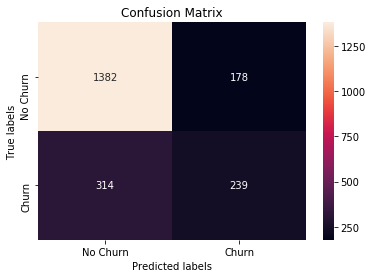

In [33]:
# distance with neighors=10
knn = neighbors.KNeighborsClassifier(n_neighbors=10 , weights='distance')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)


print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))

print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+
      str(classification_report(Y_test, Y_knn_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

Accuracy of K-Nearest Neighborhood classifier on test set:0.7761476573592049

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1560
           1       0.60      0.43      0.50       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.71      0.67      0.68      2113
weighted avg       0.76      0.78      0.76      2113

kNN cross validation scores: [0.7852077  0.77383367 0.76572008 0.78194726 0.76751269]


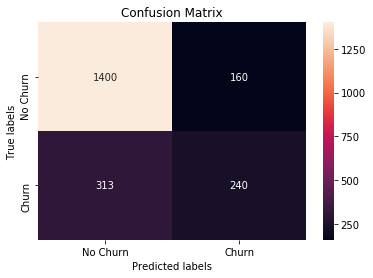

In [34]:
# 15 as number of neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=15 , weights='distance')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)


print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))

print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_knn_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

Accuracy of K-Nearest Neighborhood classifier on test set:0.7818267865593942

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1560
           1       0.62      0.43      0.51       553

   micro avg       0.78      0.78      0.78      2113
   macro avg       0.72      0.67      0.68      2113
weighted avg       0.77      0.78      0.77      2113

kNN cross validation scores: [0.78926039 0.77586207 0.77789047 0.77687627 0.76649746]


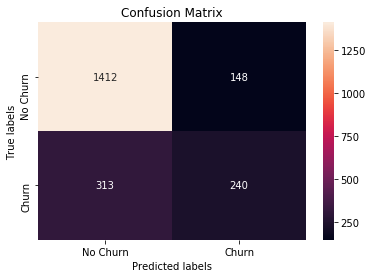

In [35]:
# 20 as number of neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=20 , weights='distance')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)


print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))

print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_knn_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

Accuracy of K-Nearest Neighborhood classifier on test set:0.7865593942262187

Classification report of K-Nearest Neighborhood classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1560
           1       0.64      0.43      0.51       553

   micro avg       0.79      0.79      0.79      2113
   macro avg       0.73      0.67      0.69      2113
weighted avg       0.77      0.79      0.77      2113

kNN cross validation scores: [0.79128673 0.77383367 0.77991886 0.78194726 0.76954315]


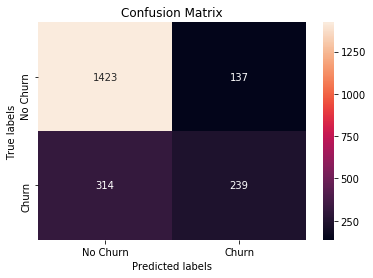

In [36]:
# 25 as number of neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=25 , weights='distance')
knn.fit(X_important_train,Y_train)
Y_knn_important_pred = knn.predict(X_important_test)


print('Accuracy of K-Nearest Neighborhood classifier on test set:'+ str(knn.score(X_important_test, Y_test)))

print('\nClassification report of K-Nearest Neighborhood classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_knn_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_knn_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

knn_result = cross_val_score(knn, X_important_train,Y_train, scoring='accuracy', cv=5)
#to compare different k-s using cross validation
print ('kNN cross validation scores: '+ str(knn_result))

* I employ two types of weights: **uniform and distance**. <br>
** Unifrom weight sets all points in each neighborhood as equally weighted.<br>
** Distance weight sets the weight of points by the inverse of their distance.

Having weights based on the distance is a better choice rather than unifrom weights. Therefore, I use distance weights and change the number of neighbors for parameter tuning.<br>
* There is no closed-form solution for calculating the number of neighbors (k). 
* Implementing cross-validation and test several different values for k can be helpful to choose the one that produces the smallest error during cross-validation.
* As the number of neighbors increases, bias tends to increase and variance decreases.

Increasing number of neighbors from 5 to 20 while using distance weights reveals improvement in the classification metrics.<br>
Using 20 neighbors results following metrics:<br>
* Accuracy of kNN classification is 77% whereas.
* Precision of kNN classification is 58% for identifying the customer churn.
* Recall of kNN classification is 45% for identifying the customer churn.

#### Random Forest Classifications:

* Random forest is an ensemble method that uses bagged decision trees with random feature subsets chosen at each split point. 
* Random forest classification uses votes from each tree to make the final prediction for customer churn.
* I use different parameters to tune the model and implement visualization for the tuning process.

In [37]:
# Create the baseline 
model_1 = RandomForestClassifier(oob_score=True, random_state=0,n_jobs=-1)


# Fit and Evaluate OOB: oob_score Random Forest's custom validation method: out-of-bag prediction
model_1 = model_1.fit(X_important_train,Y_train)

# Calculate OOB Score
print("The OOB Score is: " + str(model_1.oob_score_))

The OOB Score is: 0.7626774847870182


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [38]:
#baseline
# Create the baseline 
model_1 = RandomForestClassifier(oob_score=True, random_state=0,n_jobs=-1,class_weight='balanced')


# Fit and Evaluate OOB: oob_score Random Forest's custom validation method: out-of-bag prediction
model_1 = model_1.fit(X_important_train,Y_train)

# Calculate OOB Score
print("The OOB Score is: " + str(model_1.oob_score_))

The OOB Score is: 0.7517241379310344


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [39]:
# evaluating score by cross validation
rf_result = cross_val_score(model_1,X_important_train,Y_train, scoring='accuracy')

rf_result.mean()

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/L

0.7665300461427669

* Out-of-bag (oob) prediction is random forest's custom validation method.
* Cross validation uses the entire dataset, whereas out of bag (oob) has more variance because we use less data. 
* Oob is good for hyperparameter tuning and we still need to do cross-validation for model comparison.
* Oob may sometime create biased results.

Tuning the following parameters may improve the behavior of random model:<br>

* max_depth: The depth size of a tree.
* n_estimators: The number of trees in the forest. 
* max_features: The max number of features that the algorithm can assign to an individual tree. 
* min_samples_leaf: The minimum number of samples in newly created leaves.

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid 

1 depth
AUC Train:  0.868459662945351
AUC Test:  0.6525710576343488
 
2 depth
AUC Train:  0.8223823092566397
AUC Test:  0.6211155932674919
 
3 depth


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9201173080707751
AUC Test:  0.6661809709278064
 
4 depth


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.8929828781351817
AUC Test:  0.6318032178791673
 
5 depth


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.941988728400025
AUC Test:  0.6592108313627302
 
10 depth


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


AUC Train:  0.9542254202249609
AUC Test:  0.6613535725877497
 
20 depth
AUC Train:  0.9775772788362717
AUC Test:  0.6732223999629063
 
50 depth
AUC Train:  0.9898736844052931
AUC Test:  0.6654390967682107
 
100 depth
AUC Train:  0.9915317921019743
AUC Test:  0.6633102656836835
 


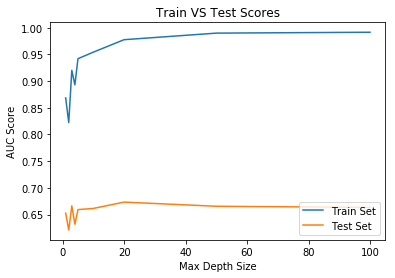

In [40]:
# tuning parmeters: max_depth / higher max_depth: more likely to overfit

results  =  []
results2 = []
max_depth_size  = [1,2,3,4,5,10,20,50,100]

for depth in max_depth_size:
    model = RandomForestClassifier(depth, oob_score=True, n_jobs=-1, random_state=0,class_weight='balanced')
    #model.fit(X, y)
    model.fit(X_important_train,Y_train)
    print(depth, 'depth')
    pred = model.predict(X_important_train)
    pred2 = model.predict(X_important_test)
    roc1 = roc_auc_score(Y_train, pred)
    roc2 = roc_auc_score(Y_test, pred2)
    print('AUC Train: ', roc1)
    print('AUC Test: ', roc2)
    results.append(roc1)
    results2.append(roc2)
    print (" ")
    
plt.plot(max_depth_size, results, label='Train Set')
plt.plot(max_depth_size, results2, label='Test Set')
plt.xlabel('Max Depth Size')
plt.ylabel('AUC Score')
plt.title('Train VS Test Scores')
plt.legend(loc="lower right")
plt.show()    

* Overfitting train set would happen as max-depth gets larger.
* Higher max_depth can add complexity to the model. So, lower max-depth is preferred.<br>
<br>
* AUC stands for "Area under the ROC Curve", and measures two-dimensional area underneath the entire ROC curve.
* An ROC (receiver operating characteristic) curve is plotted for y-axis as true positive rate and x-axis as false positive rate, where true positive rate is recall metric (ratio of true positive over summation of true positive and false negative) and false positive rate is ratio of false positive over summation of false positive and true negative.
* As AUC Train and AUC Teest move together upper the model gets better.<br> 
Based on the visualization, after max-depth =3 the model gets worse and then it started getting better slowly as max_depth increases. Hence, choosing max_depth =1 which is the default amount works pretty well.

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide b

1 trees
AUC:  0.7356997971602434
Accuracy:  0.7326076668244202
 
2 trees
AUC:  0.7397565922920892
Accuracy:  0.7576904874585897
 
3 trees
AUC:  0.7393509127789046


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.7501183151916706
 
4 trees
AUC:  0.7395537525354969


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.7510648367250355
 
5 trees
AUC:  0.7415821501014199


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.7458589682915286
 
15 trees
AUC:  0.7567951318458418


/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Accuracy:  0.7657359204921912
 
20 trees
AUC:  0.7622718052738336
Accuracy:  0.7699952673923331
 
25 trees
AUC:  0.7612576064908723
Accuracy:  0.7647893989588264
 
40 trees
AUC:  0.7620689655172413
Accuracy:  0.7628963558920966
 
50 trees
AUC:  0.7606490872210954
Accuracy:  0.7619498343587316
 
70 trees
AUC:  0.7643002028397566
Accuracy:  0.7619498343587316
 
100 trees
AUC:  0.7655172413793103
Accuracy:  0.7605300520586843
 


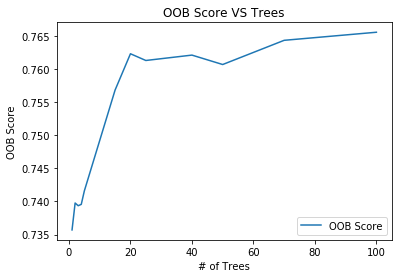

In [41]:
# n-estimator 
results = []
results_score=[]
n_estimator_options = [1, 2, 3, 4, 5, 15, 20, 25, 40, 50, 70, 100]

for trees in n_estimator_options:
    model = RandomForestClassifier(trees, oob_score=True, n_jobs=-1, random_state=0,class_weight='balanced')
    #model.fit(X, y)
    model.fit(X_important_train,Y_train)
    print(trees, 'trees')
    AUC = model.oob_score_
    print('AUC: ', AUC)
    results.append(AUC)
    score=model.score(X_important_test, Y_test)
    print('Accuracy: ', score)
    results_score.append(score)
    print (" ")
        
plt.plot(n_estimator_options, results, label='OOB Score')
plt.xlabel('# of Trees')
plt.ylabel('OOB Score')
plt.title('OOB Score VS Trees')
plt.legend(loc="lower right")
plt.show()

* Having n_estimator=1 is equivalent of having just a decision tree. Above 1 for the number of estimators results from random forest.
* More trees we have, more generalized the outcome would be (more is more and better!).
* Based on both AUC and accuracy, 20 seems a good fit for the number of estimators.

auto option
AUC:  0.7643002028397566
Accuracy:  0.7619498343587316
 
None option
AUC:  0.7614604462474645
Accuracy:  0.7643161381921438
 
log2 option
AUC:  0.7643002028397566
Accuracy:  0.7619498343587316
 
0.7 option
AUC:  0.7655172413793103
Accuracy:  0.7581637482252721
 
0.2 option
AUC:  0.7645030425963489
Accuracy:  0.7595835305253195
 


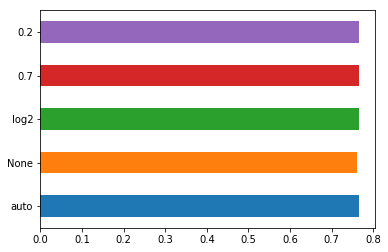

In [42]:
# none=using all feature
# auto and sqr do exactly same thing.
results = []
results_score=[]
max_features_options = ["auto", None, "log2", 0.7, 0.2]

# using 70 as n_estimators from last part
for max_features in max_features_options:
    model = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1, random_state=0,
                                   class_weight='balanced', max_features=max_features)
    model.fit(X_important_train,Y_train)
    print(max_features, "option")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    score=model.score(X_important_test, Y_test)
    print('Accuracy: ', score)
    results_score.append(score)
    print (" ")
    
pd.Series(results, max_features_options).plot(kind='barh')

* Max Features specify the number of features that random forest learns.
* Choosing the default parameter of auto for max features would be good enough.

1 min samples
AUC:  0.7643002028397566
Accuracy:  0.7619498343587316
 
2 min samples
AUC:  0.7663286004056795
Accuracy:  0.7600567912920019
 
3 min samples
AUC:  0.7645030425963489
Accuracy:  0.7638428774254614
 
4 min samples
AUC:  0.7632860040567951
Accuracy:  0.7647893989588264
 
5 min samples
AUC:  0.7632860040567951
Accuracy:  0.7610033128253668
 
6 min samples
AUC:  0.757606490872211
Accuracy:  0.759110269758637
 
7 min samples
AUC:  0.7628803245436105
Accuracy:  0.7576904874585897
 
8 min samples
AUC:  0.7567951318458418
Accuracy:  0.7600567912920019
 
9 min samples
AUC:  0.7563894523326572
Accuracy:  0.7581637482252721
 
10 min samples
AUC:  0.7578093306288033
Accuracy:  0.7562707051585423
 
20 min samples
AUC:  0.7612576064908723
Accuracy:  0.7491717936583058
 


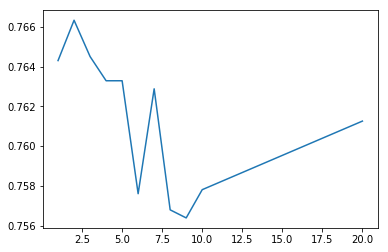

In [43]:
# min samples leaf: last node of branch, output of prediction

results = []
results_score=[]
min_samples_leaf_options = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10,20]

for min_samples in min_samples_leaf_options:
    model = RandomForestClassifier(n_estimators=70, oob_score=True, n_jobs=-1, random_state=0, 
                                   max_features="auto", min_samples_leaf=min_samples, class_weight='balanced')
    model.fit(X_important_train,Y_train)
    print(min_samples, "min samples")
    auc = model.oob_score_
    print('AUC: ', auc)
    results.append(auc)
    score=model.score(X_important_test, Y_test)
    print('Accuracy: ', score)
    results_score.append(score)
    print (" ")
    
pd.Series(results, min_samples_leaf_options).plot();

* Based on AUC and accuracy, min samples leaf of 5 seems a good choice.

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Liuna/anaconda3/lib/pyt

Cross validation accuracy: 0.7255582128889561

Classification report of random forest classifier on test set: 
              precision    recall  f1-score   support

           0       0.92      0.64      0.76      1560
           1       0.45      0.84      0.59       553

   micro avg       0.69      0.69      0.69      2113
   macro avg       0.69      0.74      0.67      2113
weighted avg       0.80      0.69      0.71      2113



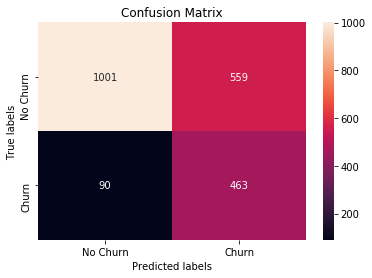

In [44]:
### finally, running the best random forest using the above results
model_rf=RandomForestClassifier(max_depth=3, oob_score=True, n_jobs=-1, random_state=0, 
                                   max_features="auto",  class_weight='balanced')
model_rf = model_rf.fit(X_important_train,Y_train)
Y_rf_important_pred = model_rf.predict(X_important_test)

rf_result = cross_val_score(model_rf,X_important_train,Y_train, scoring='accuracy')
print ('Cross validation accuracy: ' + str(rf_result.mean()))

print('\nClassification report of random forest classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_rf_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_rf_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross validation accuracy: 0.7703841674297855

Classification report of random forest classifier on test set: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1560
           1       0.57      0.47      0.52       553

   micro avg       0.77      0.77      0.77      2113
   macro avg       0.70      0.67      0.68      2113
weighted avg       0.76      0.77      0.76      2113



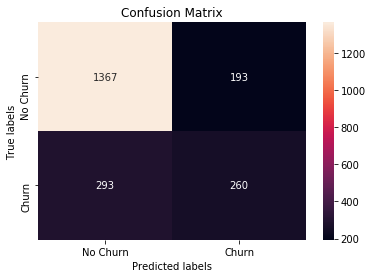

In [45]:
### second tuning
model_rf=RandomForestClassifier(n_estimators=20, oob_score=True, n_jobs=-1, random_state=0, 
                                   max_features="auto",  class_weight='balanced')
model_rf = model_rf.fit(X_important_train,Y_train)
Y_rf_important_pred = model_rf.predict(X_important_test)

rf_result = cross_val_score(model_rf,X_important_train,Y_train, scoring='accuracy')
print ('Cross validation accuracy: ' + str(rf_result.mean()))

print('\nClassification report of random forest classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_rf_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_rf_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/Liuna/anaconda3/lib/pyt

Cross validation accuracy: 0.7614633312687138

Classification report of random forest classifier on test set: 
              precision    recall  f1-score   support

           0       0.87      0.80      0.83      1560
           1       0.53      0.65      0.59       553

   micro avg       0.76      0.76      0.76      2113
   macro avg       0.70      0.73      0.71      2113
weighted avg       0.78      0.76      0.77      2113



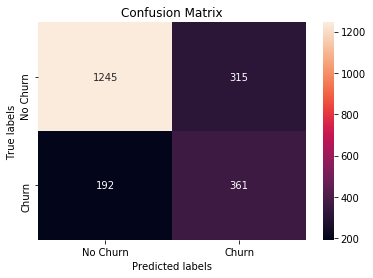

In [46]:
### thirds tuning
model_rf=RandomForestClassifier(min_samples_leaf=5 , oob_score=True, n_jobs=-1, random_state=0, 
                                   max_features="auto",  class_weight='balanced')
model_rf = model_rf.fit(X_important_train,Y_train)
Y_rf_important_pred = model_rf.predict(X_important_test)

rf_result = cross_val_score(model_rf,X_important_train,Y_train, scoring='accuracy')
print ('Cross validation accuracy: ' + str(rf_result.mean()))

print('\nClassification report of random forest classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_rf_important_pred)))

#confusion matrix
cm= confusion_matrix(Y_test, Y_rf_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

/Users/Liuna/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Cross validation accuracy: 0.7239366468008769

Classification report of random forest classifier on test set: 
              precision    recall  f1-score   support

           0       0.92      0.64      0.75      1560
           1       0.45      0.84      0.59       553

   micro avg       0.69      0.69      0.69      2113
   macro avg       0.69      0.74      0.67      2113
weighted avg       0.80      0.69      0.71      2113



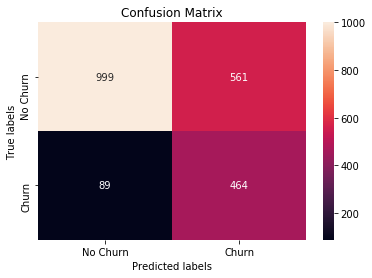

In [47]:
# all hypertuning
model_rf=RandomForestClassifier(n_estimators=20, min_samples_leaf=5,max_depth=3, oob_score=True, n_jobs=-1, 
                                random_state=0, max_features="auto",  class_weight='balanced')
model_rf = model_rf.fit(X_important_train,Y_train)
Y_rf_important_pred = model_rf.predict(X_important_test)

rf_result = cross_val_score(model_rf,X_important_train,Y_train, scoring='accuracy')
print ('Cross validation accuracy: ' + str(rf_result.mean()))

print('\nClassification report of random forest classifier on test set: \n'+ 
     str(classification_report(Y_test, Y_rf_important_pred)))
#confusion matrix
cm= confusion_matrix(Y_test, Y_rf_important_pred)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt="d"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Churn', 'Churn']); ax.yaxis.set_ticklabels(['No Churn', 'Churn']);

Considering all classification metrics, I choose the second model which have 20 as the number of trees in the forest(n_estimators) among the different random forest models.
* Accuracy of random forest classification is 77%.<br>
* Precision of random forest classification is 58%.<br>
* Recall of random forest classification is 47% for identifying the customer churn.<br>

## Applications of Customer Churn Models

* The practical uses of my model is to predict what percentage of customers churn. 
* Based on this insight, the businesses can segment customers and focus on the group of customers who are more likely to churn. 
* By setting special campaigns which target the churning customers, the businesses may be able to retain a higher percentage of their customers. 
* Besides, knowing about the causes of customer churn is informative and can provide insights into the businesses. For instance, customers churn may be due to specific new feature added to the product, so improvement in product or some changes in product design may encourage the customers to not churn.

## Challenges and Possible Solutions

* I have an imbalanced dataset. In my most of models I use **class_weight** option to deal with the imbalance of data.
* **Neural Network** models would work better for predicting customer churn.
* One of the features is customers' tenure, which is the period of the time customer leave or stay with the company, is a censored feature. 
* Censorship means that after a given point of time, it is not known to data scientist whether the customer would stay or leave.
* in this dataset we have right censorship problem.
* The correct model which provide us the probability of customer churn while dealing with time feature censorship is Survival models such as Cox model. 